In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfilt, stft, welch
from scipy.optimize import curve_fit

In [3]:
def get_psd(data, channel=1):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10
    
    ff, pp = welch(data[channel], fs=fs, nperseg=nperseg)
    return ff, pp

def peak_amplitude_stft(tod, fs, nperseg, driving_freq):
    
    ff, tt, Zxx = stft(tod, fs=fs, nperseg=nperseg)
    sig = np.abs(Zxx)
    f = np.where(ff==driving_freq)[0][0]

    # time, peak amplitude^2, sample frequency, sftp
    return tt, sig[f], ff, Zxx[f]

In [4]:
def get_filtered_signal(data, f_hp, f_lp, order=8):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0]))) * 1000 # Sampling rate in Hz
    
    sos_hp = butter(order, f_hp, 'hp', fs=fs, output='sos')
    sos_lp = butter(order, f_lp, 'lp', fs=fs, output='sos')
    
    filtered = sosfilt(sos_hp, data[1])
    filtered_filtered = sosfilt(sos_lp, filtered)
    
    return filtered_filtered

In [5]:
def plot_peak_amp(data, drive_freq):
    fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
    nperseg = fs / 10

    tt, sig, ff, Zxx = peak_amplitude_stft(data[1], fs, nperseg, drive_freq)
    
    fig, ax = plt.subplots(figsize = (20, 6))
    ax.grid()
    ax.plot(tt, sig, '-')

    ax.set_xlabel('Time (s)', fontsize=18)
    ax.set_ylabel(f'Peak amplitude@{int(drive_freq/1000)} kHz (V)', fontsize=18)
    ax.set_title('1 mbar, driving field = 20 V peak to peak', fontsize=20)
    
    return fig, ax

## Determine the charge state of the nanosphere

In [11]:
data_file = r"D:\Experiment\Charging\20231031\charging_20s_uv_4.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

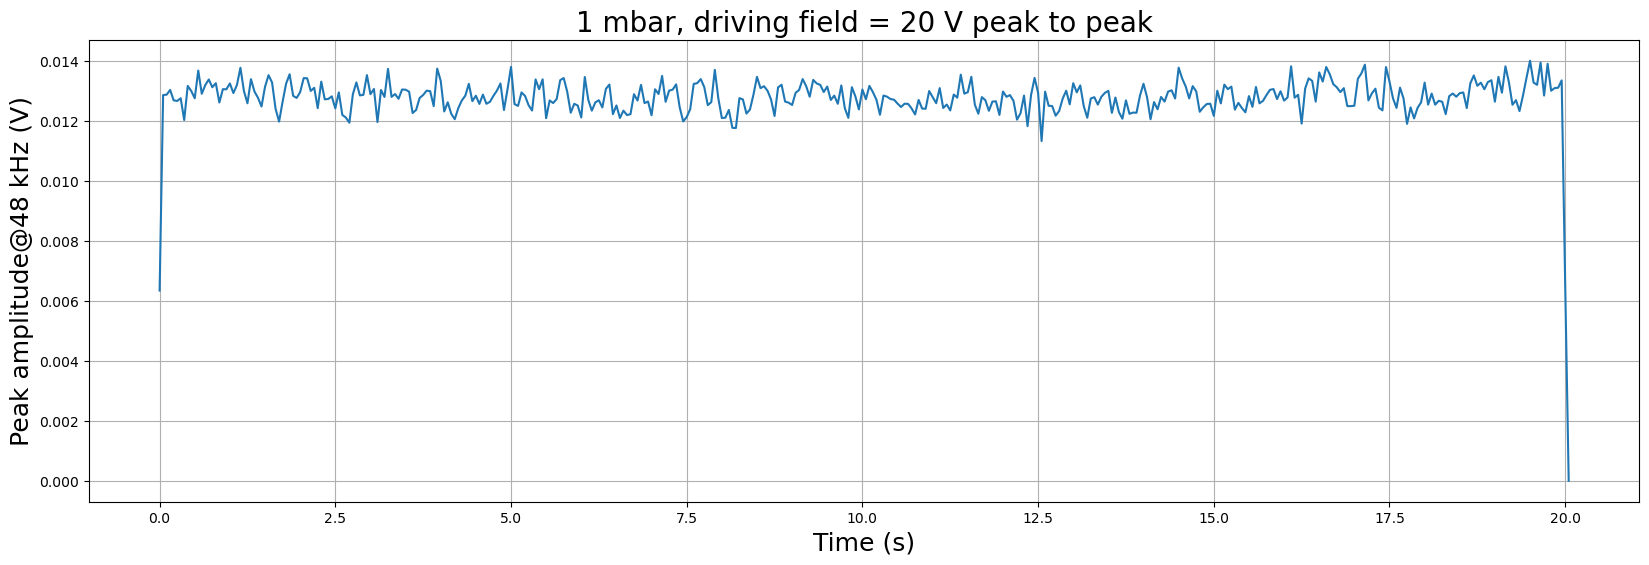

In [12]:
fig, ax = plot_peak_amp(data, 48000)

## Making some plots for my CPAD talk

In [38]:
def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

In [44]:
data_file = r"D:\Experiment\Charging\20230906\noefield_20s_5.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff, pp = get_psd(data)

In [45]:
data_file = r"D:\Experiment\Calibration\20230913\89khzonly_1s_lp_3.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

ff_l, pp_l = get_psd(data)

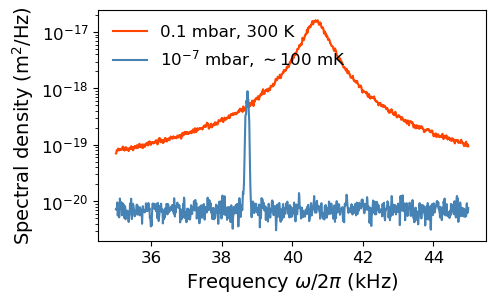

In [72]:
lb, ub = 3500, 4500
c_cal = 80179930463.28465

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(ff[lb:ub]/1000, pp[lb:ub]/c_cal, label='0.1 mbar, 300 K', color='orangered')
ax.plot(ff_l[lb:ub]/1000, pp_l[lb:ub]/c_cal, label='$10^{-7}$ mbar, $\sim$100 mK', color='steelblue')

ax.set_xlabel('Frequency $\omega / 2 \pi$ (kHz)', fontsize=14)
ax.set_ylabel('Spectral density (m$^2$/Hz)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.legend(frameon=False, fontsize=12)

ax.set_yscale('log')

In [124]:
# Calculate effective temperature
# Assume 1 mbar is 300 K
v2_low = 0.5 * np.pi/(gamma_low * omega0_low**2) * amp_low * gamma_low / (2 * np.pi)
print(f'The effective temperature is {(v2_low / v2) * 300 * (omega0_low / omega0)**2} K')

The effective temperature is 0.9104642865304302 K


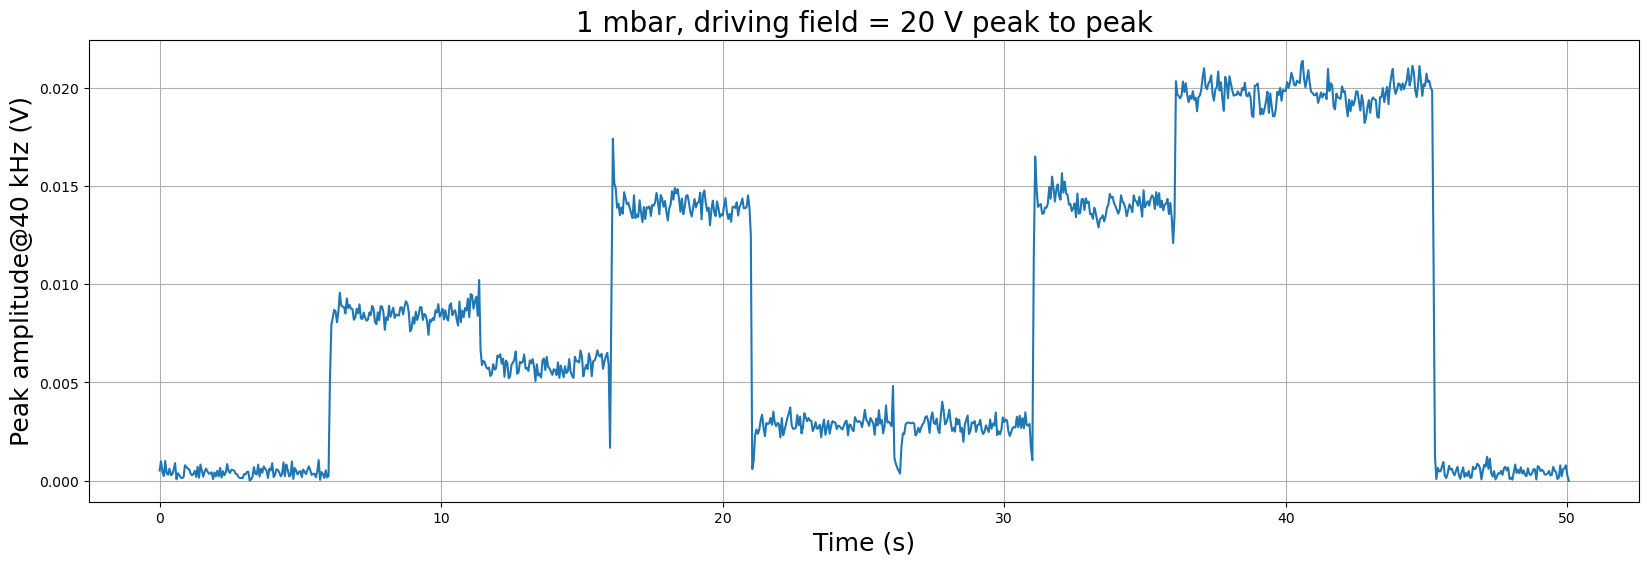

In [6]:
data_file = r"D:\Experiment\Calibration\20230913\charging_50s_40khz_hp.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

fig, ax = plot_peak_amp(data, 40000)

In [7]:
drive_freq = 40000
fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
nperseg = fs / 10

tt, sig, ff, Zxx = peak_amplitude_stft(data[1], fs, nperseg, drive_freq)

Text(0, 0.5, 'Charge ($|e|$)')

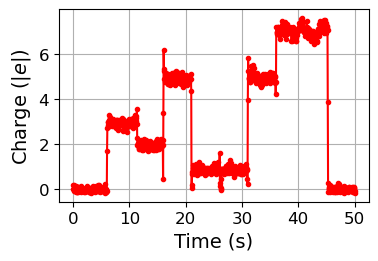

In [13]:
fig, ax = plt.subplots(figsize = (4, 2.5))

ax.plot(tt, (sig-0.0005)/0.00275, '.-r')
ax.grid(True)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel('Charge ($|e|$)', fontsize=14)